In [33]:
import pandas as pd
### make X and y
X = pd.DataFrame({'study_hours_in_a_week': [20, 30, 45, 55, 70],
                  'height(in cms)': [182, 176, 174, 168, 181],
                  'weight(in kg)': [70, 68, 78, 61, 82]})
y = pd.Series([30, 44, 60, 68, 80], name = 'marks')

pd.concat([X,y],axis=1)

,study_hours_in_a_week,height(in cms),weight(in kg),marks
0,20,182,70,30
1,30,176,68,44
2,45,174,78,60
3,55,168,61,68
4,70,181,82,80


In [34]:
import numpy as np
### make X_shadow by randomly permuting each column of X
np.random.seed(4)
X_shadow = X.apply(np.random.permutation)
X_shadow.columns = ['shuffled_' + feat for feat in X.columns]
### make X_boruta by appending X_shadow to X
X_boruta = pd.concat([X, X_shadow], axis = 1)
X_boruta

,study_hours_in_a_week,height(in cms),weight(in kg),shuffled_study_hours_in_a_week,shuffled_height(in cms),shuffled_weight(in kg)
0,20,182,70,30,168,82
1,30,176,68,45,181,78
2,45,174,78,70,182,61
3,55,168,61,55,174,70
4,70,181,82,20,176,68


In [35]:
#random forest with boruta algorithm
from sklearn.ensemble import RandomForestRegressor
#define and fit random forest
clf = RandomForestRegressor(max_depth=5)
clf.fit(X_boruta, y)
#store feature importances of shuffled features to get threshold
feature_imp_shuffled = clf.feature_importances_[len(X.columns):]
#round off feature importances for original and shuffled features to 2 decimal places
feature_imp_shuffled=[round(i*100,2) for i in feature_imp_shuffled]
feature_imp_X=[round(i*100,2) for i in feature_imp_X]
print('Threshold for feature importance:',max(feature_imp_shuffled))
for i in range(len(X_boruta.columns)):
  print(X_boruta.columns[i]+': '+str(clf.feature_importances_[i]))

Threshold for feature importance: 20.08
study_hours_in_a_week: 0.29258092742323494
height(in cms): 0.12805921124355735
weight(in kg): 0.11199052114762412
shuffled_study_hours_in_a_week: 0.1455147430371407
shuffled_height(in cms): 0.12105985595447127
shuffled_weight(in kg): 0.2007947411939717


In [32]:
#sklearn without trial
from sklearn.ensemble import RandomForestRegressor
### fit a random forest (suggested max_depth between 3 and 7)
forest = RandomForestRegressor(max_depth = 5, random_state = 42)
forest.fit(X_boruta, y)
### store feature importances
feat_imp_X = forest.feature_importances_[:len(X.columns)]
feat_imp_shadow = forest.feature_importances_[len(X.columns):]
### compute hits
hits = feat_imp_X > feat_imp_shadow.max()
print(hits)
feat_imp_shadow=[round(i*100,2) for i in feat_imp_shadow]
feat_imp_X=[round(i*100,2) for i in feat_imp_X]
print('Importance %age for shuffled features')
print(feat_imp_shadow)
print('Importance %age for unshuffled features')
print(feat_imp_X)

[ True False False]
Importance %age for shuffled features
[11.26, 12.26, 23.11]
Importance %age for unshuffled features
[30.48, 13.74, 9.15]


In [36]:
#sklearn with trial
#initialize hits list to count instances where the feature had importance > threhsold
hits = np.zeros((len(X.columns)))
#perform 20 trials
for i in range(20):
   #create X_shuffle
   np.random.seed(i)
   X_shuffle = X.apply(np.random.permutation)
   X_boruta = pd.concat([X, X_shuffle], axis = 1)
   #fit random forest
   clf = RandomForestRegressor(max_depth = 5)
   clf.fit(X_boruta, y)
   ### store feature importance
   feature_imp_X = clf.feature_importances_[:len(X.columns)]
   feature_imp_shuffled = clf.feature_importances_[len(X.columns):]
   ### compute hits for this trial and add to counter
   hits += (feature_imp_X > feature_imp_shuffled.max())
print('Hits for every feature')
for i in range(len(X.columns)):
  print(X.columns[i],':',hits[i])

Hits for every feature
study_hours_in_a_week : 14.0
height(in cms) : 3.0
weight(in kg) : 1.0


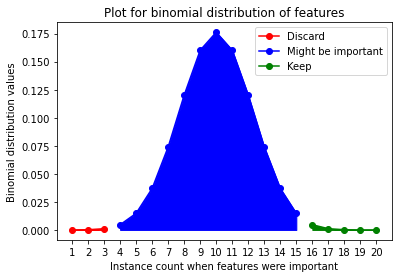

In [37]:
import scipy as sp
trials = 20
pmf = [sp.stats.binom.pmf(x, trials, .5) for x in range(1,trials + 1)]
import matplotlib.pyplot as plt
plt.xticks(np.arange(0, 21, 1)) 
plt.plot(range(1,4),pmf[:3],'-ro')
plt.plot(range(4,16),pmf[3:15],'-bo')
plt.plot(range(16,21),pmf[15:21],'-go')
plt.fill_between(range(1,4),pmf[:3] , color='red')
plt.fill_between(range(4,16),pmf[3:15] , color='blue')
plt.fill_between(range(16,21),pmf[15:21] , color='green')
plt.title('Plot for binomial distribution of features')
plt.xlabel('Instance count when features were important')
plt.ylabel('Binomial distribution values')
labels=['Discard','Might be important','Keep']
plt.legend(labels,loc='upper right')